In [98]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from meteostat import Point, Daily
from functools import reduce
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
#xgboost
from xgboost import XGBRegressor


def fetch_stock_data(tickers, start_year=2014, end_year=2024):
    all_years_data = []
    for ticker in tickers:
        for year in range(start_year, end_year + 1):
            start_date, end_date = f"{year}-01-01", f"{year}-12-31"
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date)
            if not hist.empty:
                hist.reset_index(inplace=True)
                hist['Ticker'] = ticker
                all_years_data.append(hist[['Date', 'Ticker', 'Open', 'Close', 'High', 'Low', 'Volume']])
    return pd.concat(all_years_data, ignore_index=True)

def fetch_weather_data(city_points, start_date, end_date):
    weather_frames = []
    for city_name, point in city_points.items():
        weather = Daily(point, start_date, end_date).fetch().reset_index()
        weather.rename(columns={'time': 'Date', 'tavg': f'tavg_{city_name}'}, inplace=True)
        weather = weather[['Date', f'tavg_{city_name}']]
        weather_frames.append(weather)
    return reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), weather_frames)

# Define cities for weather data
cities = {
    'NewYork': Point(40.7128, -74.0060),   # New York City, USA
    'London': Point(51.5074, -0.1278),      # London, UK
    'Paris': Point(48.8566, 2.3522),        # Paris, France
    'Tokyo': Point(35.6895, 139.6917),      # Tokyo, Japan
    'Sydney': Point(-33.8688, 151.2093),     # Sydney, Australia
    'Berlin': Point(52.5200, 13.4050),       # Berlin, Germany
    'Beijing': Point(39.9042, 116.4074),    # Beijing, China
    'Moscow': Point(55.7558, 37.6176),       # Moscow, Russia
    'Zurich': Point(47.3769, 8.5417),        # Zurich, Switzerland
    'Madrid': Point(40.4168, -3.7038),        # Madrid, Spain
    'Toronto': Point(43.65107, -79.347015),  # Toronto, Canada
    'Vienna': Point(48.20849, 16.37208),     # Vienna, Austria
    'Rome': Point(41.9028, 12.4964),         # Rome, Italy
    'Istanbul': Point(41.0082, 28.9784),     # Istanbul, Turkey
    'Cairo': Point(30.0330, 31.2336),        # Cairo, Egypt
    'CapeTown': Point(-33.9249, 18.4241),    # Cape Town, South Africa
    'Rio': Point(-22.9068, -43.1729),        # Rio de Janeiro, Brazil
    'MexicoCity': Point(19.4326, -99.1332),  # Mexico City, Mexico
    'Mumbai': Point(19.0760, 72.8777),       # Mumbai, India
    'Bangkok': Point(13.7563, 100.5018),     # Bangkok, Thailand
    'Singapore': Point(1.3521, 103.8198),    # Singapore
    'Seoul': Point(37.5665, 126.9780),       # Seoul, South Korea
    'Taipei': Point(25.0330, 121.5654),      # Taipei, Taiwan
    'HongKong': Point(22.3193, 114.1694),    # Hong Kong
    'Dubai': Point(25.276987, 55.296249),    # Dubai, UAE
    'SaoPaulo': Point(-23.5505, -46.6333),   # Sao Paulo, Brazil

}

# Fetching stock and weather data
combined_stock_data = fetch_stock_data(['GOOGL','AAPL','AMZN','MSFT','TSLA','NVDA'])
weather_data = fetch_weather_data(cities, datetime(2014, 1, 1), datetime(2023, 12, 31))

# Merging data on 'Date'
final_data = pd.concat([combined_stock_data, weather_data], axis=1, join='inner')
#keep only one column for date
#final_data = final_data.loc[:,~final_data.columns.duplicated()]
#print amount of nan values
print(final_data.isna().sum())
#drop rows with nan values
final_data = final_data.dropna()
print(final_data.isna().sum())
#reset index
final_data = final_data.reset_index(drop=True)
#save data to csv
final_data.to_csv('final_data.csv')


final_data.head()

print("unique_stock_tickers", final_data['Ticker'].unique())


Date                  0
Ticker                0
Open                  0
Close                 0
High                  0
Low                   0
Volume                0
Date                  0
tavg_NewYork          0
tavg_London           0
tavg_Paris            0
tavg_Tokyo            0
tavg_Sydney           1
tavg_Berlin           0
tavg_Beijing          0
tavg_Moscow          32
tavg_Zurich           0
tavg_Madrid           1
tavg_Toronto          0
tavg_Vienna           0
tavg_Rome             0
tavg_Istanbul        18
tavg_Cairo           75
tavg_CapeTown         1
tavg_Rio              1
tavg_MexicoCity    1413
tavg_Mumbai           0
tavg_Bangkok          0
tavg_Singapore        0
tavg_Seoul            0
tavg_Taipei          62
tavg_HongKong        59
tavg_Dubai            0
tavg_SaoPaulo         1
dtype: int64
Date               0
Ticker             0
Open               0
Close              0
High               0
Low                0
Volume             0
Date               0
tav

In [84]:
data = final_data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype                           
---  ------           --------------  -----                           
 0   Date             2352 non-null   datetime64[ns, America/New_York]
 1   Ticker           2352 non-null   object                          
 2   Open             2352 non-null   float64                         
 3   Close            2352 non-null   float64                         
 4   High             2352 non-null   float64                         
 5   Low              2352 non-null   float64                         
 6   Volume           2352 non-null   int64                           
 7   tavg_NewYork     2352 non-null   float64                         
 8   tavg_London      2352 non-null   float64                         
 9   tavg_Paris       2352 non-null   float64                         
 10  tavg_Tokyo       2352 non-null   flo

In [85]:
# Splitting the data into train and test sets
#Date to index
data['Date'] = pd.to_datetime(data['Date'])



train = data[data['Date'] < '2020-01-01']
test = data[data['Date'] >= '2020-01-01']

In [86]:
x_train = train.drop(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open','Volume'], axis=1)
x_train.info()
y_train = train['Close']

x_test = test.drop(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open','Volume'], axis=1)
y_test = test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

#train the xgboost model

model = XGBRegressor(n_estimators=10000)  # Adjust parameters as needed


model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=True)

#predict the close price
y_train_pred = model.predict(X_train_scaled)

y_test_pred = model.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 0 to 2351
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ticker           1615 non-null   object 
 1   tavg_NewYork     1615 non-null   float64
 2   tavg_London      1615 non-null   float64
 3   tavg_Paris       1615 non-null   float64
 4   tavg_Tokyo       1615 non-null   float64
 5   tavg_Sydney      1615 non-null   float64
 6   tavg_Berlin      1615 non-null   float64
 7   tavg_Beijing     1615 non-null   float64
 8   tavg_Moscow      1615 non-null   float64
 9   tavg_Zurich      1615 non-null   float64
 10  tavg_Madrid      1615 non-null   float64
 11  tavg_Toronto     1615 non-null   float64
 12  tavg_Vienna      1615 non-null   float64
 13  tavg_Rome        1615 non-null   float64
 14  tavg_Istanbul    1615 non-null   float64
 15  tavg_Cairo       1615 non-null   float64
 16  tavg_CapeTown    1615 non-null   float64
 17  tavg_Rio         16

ValueError: could not convert string to float: 'AMZN'

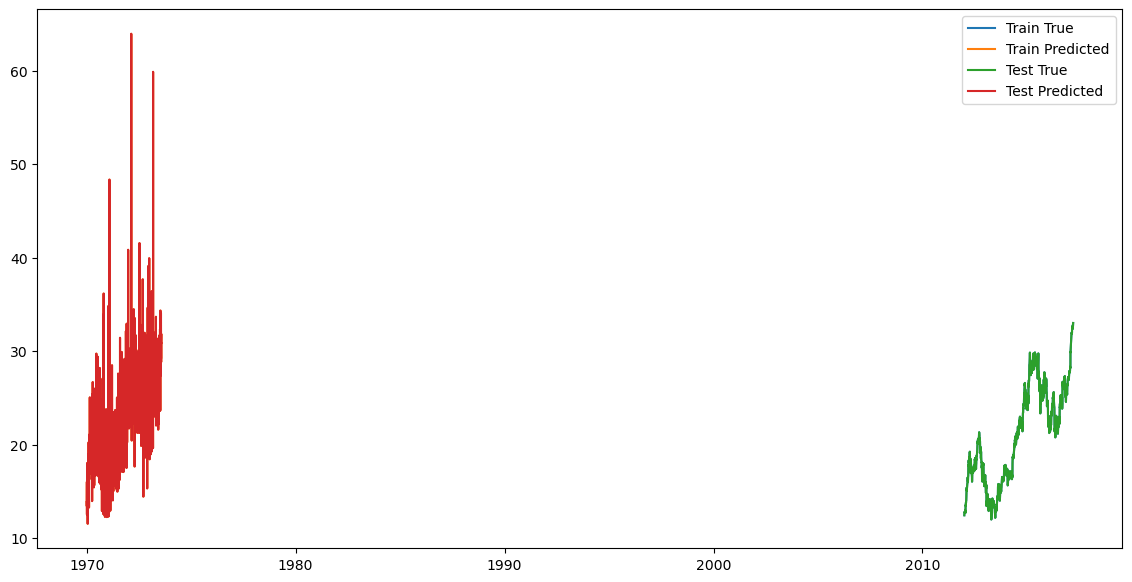

In [102]:
#plot train and test predictions for AAPL
import matplotlib.pyplot as plt

#predict the close price
data_train_aapl = data[data['Ticker'] == 'AAPL']
data_test_aapl = data[data['Ticker'] == 'AAPL']

x_train_aapl = data_train_aapl.drop(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open','Volume'], axis=1)
y_train_aapl = data_train_aapl['Close']

x_test_aapl = data_test_aapl.drop(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open','Volume'], axis=1)
y_test_aapl = data_test_aapl['Close']

scaler = StandardScaler()
X_train_scaled_aapl = scaler.fit_transform(x_train_aapl)
X_test_scaled_aapl = scaler.transform(x_test_aapl)

train_predicted_aapl = model.predict(X_train_scaled_aapl)
test_predicted_aapl = model.predict(X_test_scaled_aapl)

plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()



